<a href="https://colab.research.google.com/github/aryan619348/Dog_vs_Cats_CNN/blob/main/Transfer_Learning_Cats_vs_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we will be using tranfer learning to explore cats vs dogs dataset from kaggle

In transfer learning, the knowledge of an already trained machine learning model is applied to a different but related problem.

To do this lets import the Inception model that was trained on an dataset from imagenet that has around 1.4 million images, in a 1000 different classes

First lets download the weights form a pre-trained inception network and instantiate a new instance of it using those weights

We will pull on of the convolutional layers as our input layer and then take its output.

In [1]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-11-28 15:10:11--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.214.128, 108.177.111.128, 108.177.121.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  96.2MB/s    in 0.9s    

2021-11-28 15:10:12 (96.2 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [2]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


Now lets setup a model taking "last_output" as the input to it...

That will be flattened and thenthere will be a dense layer, a dropout, and an output layer.

In [3]:
from tensorflow.keras.optimizers import RMSprop
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)  # Add a dropout rate of 0.2             
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

Now lets import the cats vs dogs data set and use image augmentation to generate the training data set

In [4]:
!gdown --id 1RL0T7Rg4XqQNRCkjfnLo4goOJQ7XZro9

Downloading...
From: https://drive.google.com/uc?id=1RL0T7Rg4XqQNRCkjfnLo4goOJQ7XZro9
To: /content/cats_and_dogs_filtered.zip
100% 68.6M/68.6M [00:00<00:00, 166MB/s]


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

zip_ref = zipfile.ZipFile("./cats_and_dogs_filtered.zip", 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

In [6]:
base_dir = 'tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')

In [7]:
train_cats_dir = os.path.join(train_dir, 'cats') 
train_dogs_dir = os.path.join(train_dir, 'dogs') 
test_cats_dir = os.path.join(validation_dir, 'cats')
test_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

train_data_gen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
train_generator = train_data_gen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))  

test_data_gen = ImageDataGenerator( rescale = 1.0/255.)
test_generator =  test_data_gen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
history = model.fit(
            train_generator,
            validation_data = test_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 1)

Epoch 1/20
100/100 [==============================] - 38s 251ms/step - loss: 0.3521 - accuracy: 0.8535 - val_loss: 0.0966 - val_accuracy: 0.9620
Epoch 2/20
100/100 [==============================] - 23s 229ms/step - loss: 0.2179 - accuracy: 0.9150 - val_loss: 0.1041 - val_accuracy: 0.9610
Epoch 3/20
100/100 [==============================] - 24s 238ms/step - loss: 0.1888 - accuracy: 0.9270 - val_loss: 0.1360 - val_accuracy: 0.9510
Epoch 4/20
100/100 [==============================] - 23s 229ms/step - loss: 0.2012 - accuracy: 0.9305 - val_loss: 0.1021 - val_accuracy: 0.9630
Epoch 5/20
100/100 [==============================] - 24s 236ms/step - loss: 0.1807 - accuracy: 0.9360 - val_loss: 0.1232 - val_accuracy: 0.9580
Epoch 6/20
100/100 [==============================] - 23s 228ms/step - loss: 0.1548 - accuracy: 0.9490 - val_loss: 0.1297 - val_accuracy: 0.9570
Epoch 7/20
100/100 [==============================] - 24s 236ms/step - loss: 0.1771 - accuracy: 0.9440 - val_loss: 0.1440 - val_ac

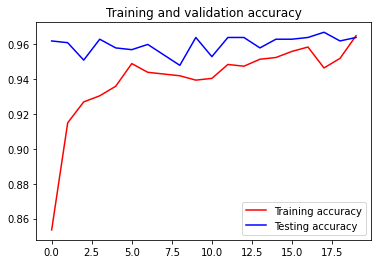

<Figure size 432x288 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Testing accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

Here we see an amazing result where the traning accuracy increases to around 96% and and testing accuracy is also at 96%